In [63]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [64]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# import data directly from google sheets

In [226]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1BshhQvcBOhqW4OPkMHXkZBdz9zYvS9q4ockW9yKufGQ') # specific doc for report

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [179]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

## for offline excel file (when you gotta do work without internet)

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [180]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [181]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [182]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [183]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [184]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

## add Total row to km by country/region

# projects by country, by region

In [185]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_country_df[status] = country_ratios_gas_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


# numbers of pipes finished in a given year

In [186]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Oil')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [187]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Oil')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [188]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Gas')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [189]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [190]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [191]:
pipes_indev_startyear.unstack()

StartYearEarliest,"2,018.00000","2,019.00000","2,020.00000","2,021.00000","2,022.00000","2,023.00000","2,024.00000","2,025.00000","2,026.00000","2,027.00000","2,028.00000","2,029.00000","2,030.00000","2,034.00000","2,035.00000","2,046.00000",NaN
Status,,,,,,,,,,,,,,,,,
Construction,873.00000,NaN,NaN,34.76000,"30,628.74000","13,131.90000","5,100.24000","1,957.00000",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"17,579.25000"
Proposed,NaN,450.00000,38.00000,NaN,"6,149.63000","8,934.45000","9,917.30000","10,938.25000","3,432.67000","3,530.00000","5,296.97000",942.00000,"3,810.26000",315.00000,110.00000,"5,660.00000","80,087.96000"
Shelved,NaN,221.70000,"1,100.70000","5,159.62000","3,795.37000","3,353.45000","1,308.40000","1,329.00000",NaN,150.00000,636.00000,135.00000,NaN,NaN,NaN,NaN,"21,078.02000"


## Fig 2 - 2023–2030, go back to 2008

In [192]:
#pandas.DataFrame(pipes_started_sum).to_excel('saved-tables/pipelines-operating-km-by-start-year.xlsx')

#pandas.DataFrame(pipes_indev_startyear).unstack().replace(numpy.nan,0).to_excel('saved-tables/pipelines-indev-km-by-start-year.xlsx')

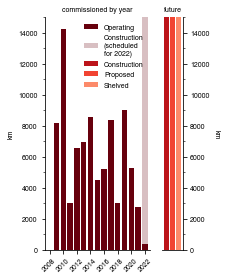

In [193]:
font_size = 7

ytop = 15000
ytop2 = 15000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    if s in ['Proposed','Shelved']:
        ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
                 color=c, label=s))
    else:
        ax2_list.append(ax2.bar(x, pipes_indev[s],
                 color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])


ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022.pdf', bbox_inches='tight', transparent=True)

## alt for David

In [194]:
pipes_indev

Status
Construction    69,304.89000
Proposed       139,612.49000
Shelved         38,267.26000
Name: LengthMergedKm, dtype: float64

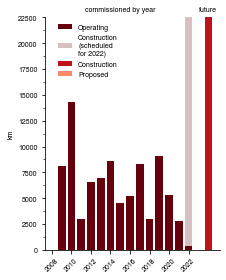

In [195]:
font_size = 7

ytop = 22500
ytop2 = 22500

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []
# for x,c,s in zip(xvals,colors,status):
#     if s in ['Proposed','Shelved']:
#         ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
#                  color=c, label=s))
#     else:
#         ax2_list.append(ax2.bar(x, pipes_indev[s],
#                  color=c, label=s))
ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2022],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

#ax2.yaxis.tick_right()
#ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
#ax2.yaxis.set_label_position('right')
ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022-alt.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022-alt.pdf', bbox_inches='tight', transparent=True)

In [196]:
pipes_indev

Status
Construction    69,304.89000
Proposed       139,612.49000
Shelved         38,267.26000
Name: LengthMergedKm, dtype: float64

## plus/minus 8 years

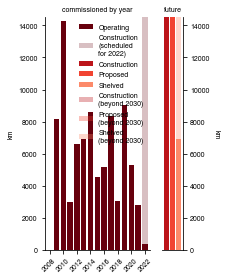

In [197]:
font_size = 7

ytop = 14500
ytop2 = 14500

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
status_alt = ['Construction\n(beyond 2030)', 'Proposed\n(beyond 2030)', 'Shelved\n(beyond 2030)']
ax2_list = []

for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev_to2030[s],
             color=c, label=s))

for x,c,s,s_alt in zip(xvals,colors,status,status_alt):
    ax2_list.append(ax2.bar(x, pipes_indev[s], bottom=pipes_indev_to2030[s],
             color=c, label=s_alt, alpha=0.333))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.pdf', bbox_inches='tight', transparent=True)

## percent pipelines with start date (sanity check)

In [198]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [199]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.5509641873278237

## regional pipelines started in given year

In [200]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [201]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [202]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

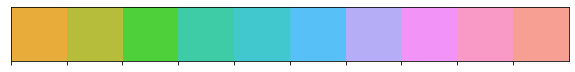

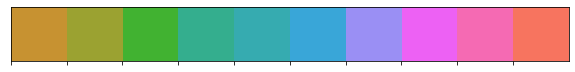

In [203]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

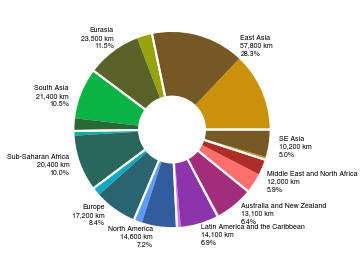

In [204]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

#mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

#mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.png', 
#           bbox_inches='tight', 
#           transparent=True,
#           dpi=600)

# top 20 countries proposed+construction

In [205]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

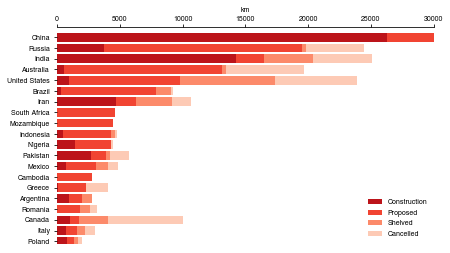

In [206]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,30000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
#mp.savefig('saved-figures/oil-pipelines_top-20-countries.png',
#          bbox_inches='tight', 
#          transparent=True,
#          dpi=600)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf',
#          bbox_inches='tight', 
#          transparent=True)

# top 20 without cancelled and shelved bars

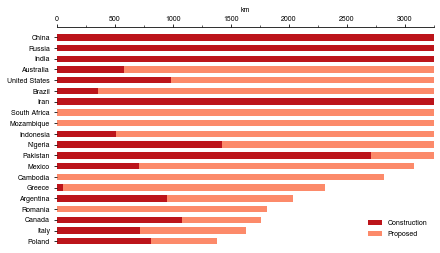

In [207]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,3250)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
#mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.png',
#          bbox_inches='tight', 
#          transparent=True,
#          dpi=600)
#
#mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.pdf',
#          bbox_inches='tight', 
#          transparent=True)

In [208]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.400827239906238

# parent analysis

### companies invested in Russian infrastructure?

it's really just ProjectIDs 2044 (Caspian Oil Pipeline), 3675 (Vostok Oil Pipeline), and 3679 (Sabo-Dagi Oil Pipeline)

## biggest parent companies for in-dev stuff?

### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

### total emissions globally (known capacity is at about 67%)

### diameter analysis

to see if it's useful to estimate missing capacities from diameter

looks like this could be possible using a log-linear plot (below), though this would only buy us an additional 15 data points, which isn't worth it to me

### how many could you add by extrapolating capacity?

it's about 15, not really enough to do that, I think

that would take it up to about 84% capacity info

### count fraction of available capacity information

count

fraction

median capacity for a pipeline is about 10.74 bcm/y

median abs dist from the median is about 10.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

In [209]:
outliers_projectids = ['P2509','P0173','P1297', 'P4033', 'P0174','P3188','P2551', 'P4069', 'P0331', 'P1382','P0477']
# for gas...

In [210]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Gas') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0) &
                                    #(country_ratios_df['CostUSDPerKm']<10e6) &
                                    ~(country_ratios_df['ProjectID'].isin(outliers_projectids))
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [211]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

3099032.317801933

### calculate regional costs

In [212]:
pipes_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Region']==region]
    pipes_costs_region_df.loc[region]['CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_costs_region_df.loc[region]['NumberOfCosts'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    pipes_costs_region_df.loc[region]['NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


### table for methodology with regional cost info

In [213]:
pipes_costs_region_df

,CostUSDPerKm,NumberOfCosts,NumberOfLengths
Australia and New Zealand,1306846,10,10
East Asia,1701998,55,55
Eurasia,4115383,46,46
Europe,3129315,111,111
Latin America and the Caribbean,3502921,24,24
Middle East and North Africa,2809259,31,31
North America,4723158,140,140
SE Asia,2366359,8,8
South Asia,1663439,17,17
Sub-Saharan Africa,4001946,5,5


### calculate country-level costs

In [215]:
#country_list_for_costs = sorted(list(set(country_ratios_with_length_and_cost_df['Country'])))
pipes_costs_country_df = pandas.DataFrame(0, index=country_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for country in country_list:#_for_costs:
    #print(country)
    country_ratios_country_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Country']==country]
    pipes_costs_country_df.loc[country,'CostUSDPerKm'] = country_ratios_country_df['CostUSDPerKm'].mean()
    pipes_costs_country_df.loc[country,'NumberOfCosts'] = list(set(country_ratios_country_df['ProjectID'])).__len__()
    pipes_costs_country_df.loc[country,'NumberOfLengths'] = list(set(country_ratios_country_df['ProjectID'])).__len__()

# tables etc.

## table for regional totals

In [216]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,"31,380.90000","26,377.70000","57,758.60000","2,065.71000",475.27000,"92,288.09000",0.00000,0.00000,41.00000
Eurasia,"18,321.40000","5,153.38000","23,474.78000",272.16000,"6,647.69000","128,934.76000",0.00000,"3,300.05000","1,784.94000"
South Asia,"4,221.03000","17,140.20000","21,361.23000","6,357.71000","6,143.81000","29,669.32000",0.00000,0.00000,35.00000
Sub-Saharan Africa,"18,823.08000","1,582.00000","20,405.08000","1,678.15000",176.96000,"7,031.52000",0.00000,0.00000,0.00000
Europe,"14,399.21000","2,836.20000","17,235.41000","5,705.03000","14,014.71000","110,152.27000",0.00000,"4,734.21000",821.36000
North America,"11,837.51000","2,768.33000","14,605.84000","10,916.42000","13,243.21000","420,872.56000",331.00000,0.00000,0.00000
Latin America and the Caribbean,"12,772.26000","1,304.00000","14,076.26000","2,187.28000","1,301.38000","39,241.07000",0.00000,224.00000,0.00000
Australia and New Zealand,"12,563.28000",580.00000,"13,143.28000",488.23000,"6,194.69000","31,025.88000",0.00000,0.00000,0.00000
Middle East and North Africa,"5,269.15000","6,726.91000","11,996.06000","5,963.24000","4,144.74000","44,502.38000",0.00000,"1,106.60000",39.28000
SE Asia,"9,222.66000",984.30000,"10,206.96000","2,634.21000","1,423.81000","16,879.66000",0.00000,0.00000,0.00000


## table for km by country

In [217]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

#km_by_country_df.to_excel('GGIT-km-by-country.xlsx')

# table for stranded asset calculations

## country-level capex estimates

In [218]:
country_ratios_gas_df['CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_gas_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_gas_df.loc[idx,'CostUSDEstimate'] = pipes_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna())]['LengthKnownKmByCountry'] * \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna())]['CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_gas_df.loc[(country_ratios_gas_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_30975/3191961253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_gas_df['CostUSDEstimate'] = numpy.nan
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a c

In [219]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df.Status==status]
    capex_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df.Status==status]
    capex_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [220]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [221]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [222]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

In [223]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

In [224]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,46.6,38.7,85.4,2.3,2.1,154.6,0.0,0.0,0.1
North America,64.7,13.9,78.6,56.4,87.6,"1,869.6",1.6,0.0,0.0
Eurasia,53.9,20.9,74.9,1.7,19.6,541.2,0.0,13.6,4.1
Sub-Saharan Africa,58.4,4.0,62.5,0.4,0.0,28.1,0.0,0.0,0.0
Europe,36.3,5.9,42.2,16.7,46.0,277.6,0.0,14.2,2.6
Middle East and North Africa,19.3,20.8,40.1,16.6,5.5,120.4,0.0,3.1,0.0
Latin America and the Caribbean,33.2,3.4,36.6,9.9,4.4,137.5,0.0,0.8,0.0
South Asia,7.4,26.1,33.5,2.0,9.9,46.4,0.0,0.0,0.1
SE Asia,19.2,2.7,21.9,2.3,3.4,39.6,0.0,0.0,0.0
Australia and New Zealand,13.8,0.8,14.5,0.4,7.0,39.7,0.0,0.0,0.0


## print out country-level stranded assets for Jenny's report

In [225]:
country_list_gas_plants_report = ['China',
                                  'Vietnam',
                                  'Indonesia',
                                  'India',
                                  'Bangladesh',
                                  'South Korea',
                                  'Philippines',
                                  'Japan']

pandas.options.display.float_format = '{:,.5f}'.format
capex_by_country_df.loc[country_list_gas_plants_report,['Proposed','Construction']].reindex(country_list_gas_plants_report)

,Proposed,Construction
China,44.09012,38.52779
Vietnam,1.77714,0.92840
Indonesia,5.71627,1.05075
India,3.52764,18.20719
Bangladesh,1.23427,0.24952
South Korea,0.00000,0.00000
Philippines,0.00000,0.00308
Japan,0.08067,0.17600
